In [1]:
%matplotlib inline

import multiprocessing
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
from itertools import islice

import random
from pathlib import Path
import pandas as pd
import os
# import matplotlib.pyplot as plt
from glob import glob
from hashlib import sha1

In [2]:
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.torch.distributions import NormalOutput

from pytorch_lightning.loggers import CSVLogger
from datasets import load_dataset

from estimator import NSTransformerEstimator

from pytorch_lightning.loggers import CSVLogger, WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, DeviceStatsMonitor, EarlyStopping


2023-11-16 19:45:49.091707: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-16 19:45:49.134953: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
dataset = get_dataset("electricity")

In [4]:
seed = 0
experiment_name = "nstransformer"
fulldir = experiment_name + "/" + str(seed)
os.makedirs(fulldir, exist_ok=True)


# Code to retrieve the version with the highest #epoch stored and restore it incl directory and its checkpoint
lightning_version_to_use, ckpt_path = None, None
max_epoch = -1
if "nstransformer" in os.listdir(fulldir):
    ckpts = glob(fulldir+ sha1(fulldir.encode("utf-8")).hexdigest()[:8] + "/checkpoints/*.ckpt")
    if len(ckpts): ckpt_path = ckpts[0]
elif "lightning_logs" in os.listdir(fulldir):
    for lightning_version in os.listdir(fulldir+"/lightning_logs/"):
        ckpts = glob(fulldir+"/lightning_logs/" + lightning_version + "/checkpoints/*.ckpt")
        if len(ckpts):
            epoch = int(ckpts[0][ckpts[0].find("=")+1:ckpts[0].find("-step")])
            if epoch > max_epoch:
                lightning_version_to_use = lightning_version
                max_epoch = epoch
                ckpt_path = ckpts[0]
    if lightning_version_to_use: print("Using lightning_version", lightning_version_to_use, "with epoch", max_epoch, "restoring from checkpoint at path", ckpt_path)


experiment_logger = CSVLogger(save_dir=fulldir)
logger = [experiment_logger]
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=50, verbose=True, mode="min")
callbacks=[early_stop_callback]

In [5]:
estimator = NSTransformerEstimator(
        # freq=dataset.metadata.freq,
        prediction_length=dataset.metadata.prediction_length,
        context_length=dataset.metadata.prediction_length*6,
        
        # num_feat_static_cat=len(dataset.metadata.feat_static_cat),
        # cardinality=[int(cat_feat_info.cardinality) for cat_feat_info in dataset.metadata.feat_static_cat],
        # embedding_dimension=[4],
        
        nhead=2,
        num_encoder_layers=4,
        num_decoder_layers=2,
        dim_feedforward=16,
        activation="gelu",
#         distr_output=NormalOutput(),
        
        batch_size=256,
        num_batches_per_epoch=100,
        trainer_kwargs=dict(max_epochs=50, accelerator='gpu', devices=1, logger=logger, callbacks=callbacks),
        ckpt_path = ckpt_path
)

In [6]:
predictor = estimator.train(
    training_data=dataset.train,
    validation_data=dataset.test,
    shuffle_buffer_length=1024,
    ckpt_path = ckpt_path)


/ccs/proj/csc499/hstellar/py38/lib/python3.8/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type               | Params
---------------------------------------------
0 | model | NSTransformerModel | 278 K 
---------------------------------------------
278 K     Trainable params
0         Non-trainable params
278 K     Total params
1.114     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 5.238
Epoch 0, global step 100: 'val_loss' reached 5.23751 (best 5.23751), saving model to 'nstransformer/0/lightning_logs/version_1/checkpoints/epoch=0-step=100.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 5.209
Epoch 1, global step 200: 'val_loss' reached 5.20867 (best 5.20867), saving model to 'nstransformer/0/lightning_logs/version_1/checkpoints/epoch=1-step=200.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.096 >= min_delta = 0.0. New best score: 5.113
Epoch 2, global step 300: 'val_loss' reached 5.11304 (best 5.11304), saving model to 'nstransformer/0/lightning_logs/version_1/checkpoints/epoch=2-step=300.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.082 >= min_delta = 0.0. New best score: 5.031
Epoch 3, global step 400: 'val_loss' reached 5.03146 (best 5.03146), saving model to 'nstransformer/0/lightning_logs/version_1/checkpoints/epoch=3-step=400.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 4.994
Epoch 5, global step 600: 'val_loss' reached 4.99372 (best 4.99372), saving model to 'nstransformer/0/lightning_logs/version_1/checkpoints/epoch=5-step=600.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 4.977
Epoch 8, global step 900: 'val_loss' reached 4.97710 (best 4.97710), saving model to 'nstransformer/0/lightning_logs/version_1/checkpoints/epoch=8-step=900.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 1000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 1100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 4.975
Epoch 11, global step 1200: 'val_loss' reached 4.97525 (best 4.97525), saving model to 'nstransformer/0/lightning_logs/version_1/checkpoints/epoch=11-step=1200.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 4.944
Epoch 12, global step 1300: 'val_loss' reached 4.94365 (best 4.94365), saving model to 'nstransformer/0/lightning_logs/version_1/checkpoints/epoch=12-step=1300.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 4.931
Epoch 13, global step 1400: 'val_loss' reached 4.93075 (best 4.93075), saving model to 'nstransformer/0/lightning_logs/version_1/checkpoints/epoch=13-step=1400.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 14, global step 1500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 15, global step 1600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 16, global step 1700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 17, global step 1800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 4.925
Epoch 18, global step 1900: 'val_loss' reached 4.92519 (best 4.92519), saving model to 'nstransformer/0/lightning_logs/version_1/checkpoints/epoch=18-step=1900.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 4.925
Epoch 19, global step 2000: 'val_loss' reached 4.92453 (best 4.92453), saving model to 'nstransformer/0/lightning_logs/version_1/checkpoints/epoch=19-step=2000.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 4.901
Epoch 20, global step 2100: 'val_loss' reached 4.90130 (best 4.90130), saving model to 'nstransformer/0/lightning_logs/version_1/checkpoints/epoch=20-step=2100.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 21, global step 2200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 22, global step 2300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 23, global step 2400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 4.888
Epoch 24, global step 2500: 'val_loss' reached 4.88792 (best 4.88792), saving model to 'nstransformer/0/lightning_logs/version_1/checkpoints/epoch=24-step=2500.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 25, global step 2600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 4.887
Epoch 26, global step 2700: 'val_loss' reached 4.88675 (best 4.88675), saving model to 'nstransformer/0/lightning_logs/version_1/checkpoints/epoch=26-step=2700.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 4.877
Epoch 27, global step 2800: 'val_loss' reached 4.87668 (best 4.87668), saving model to 'nstransformer/0/lightning_logs/version_1/checkpoints/epoch=27-step=2800.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 28, global step 2900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 29, global step 3000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 30, global step 3100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 31, global step 3200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 4.864
Epoch 32, global step 3300: 'val_loss' reached 4.86408 (best 4.86408), saving model to 'nstransformer/0/lightning_logs/version_1/checkpoints/epoch=32-step=3300.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 33, global step 3400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 34, global step 3500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 4.863
Epoch 35, global step 3600: 'val_loss' reached 4.86274 (best 4.86274), saving model to 'nstransformer/0/lightning_logs/version_1/checkpoints/epoch=35-step=3600.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 36, global step 3700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 37, global step 3800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 4.855
Epoch 38, global step 3900: 'val_loss' reached 4.85527 (best 4.85527), saving model to 'nstransformer/0/lightning_logs/version_1/checkpoints/epoch=38-step=3900.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 39, global step 4000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 40, global step 4100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 41, global step 4200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 42, global step 4300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 4.854
Epoch 43, global step 4400: 'val_loss' reached 4.85388 (best 4.85388), saving model to 'nstransformer/0/lightning_logs/version_1/checkpoints/epoch=43-step=4400.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 44, global step 4500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 4.854
Epoch 45, global step 4600: 'val_loss' reached 4.85366 (best 4.85366), saving model to 'nstransformer/0/lightning_logs/version_1/checkpoints/epoch=45-step=4600.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 46, global step 4700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 47, global step 4800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 4.845
Epoch 48, global step 4900: 'val_loss' reached 4.84510 (best 4.84510), saving model to 'nstransformer/0/lightning_logs/version_1/checkpoints/epoch=48-step=4900.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 49, global step 5000: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=50` reached.


In [7]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor,
)

In [8]:
forecasts = list(forecast_it)

In [9]:
tss = list(ts_it)

In [10]:
# num_workers is limited to 10 if cpu has more cores
num_workers = min(multiprocessing.cpu_count(), 10)

evaluator = Evaluator(num_workers=num_workers)

In [11]:
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 2247it [00:00, 11562.74it/s]
/ccs/proj/csc499/hstellar/py38/lib/python3.8/site-packages/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/ccs/proj/csc499/hstellar/py38/lib/python3.8/site-packages/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/ccs/proj/csc499/hstellar/py38/lib/python3.8/site-packages/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/ccs/proj/csc499/hstellar/py38/lib/python3.8/site-packages/pandas/core/dtypes/astype.py:170: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [12]:
agg_metrics

{'MSE': 1625831.7108473429,
 'abs_error': 8053022.00142951,
 'abs_target_sum': 128632956.0,
 'abs_target_mean': 2385.272140631954,
 'seasonal_error': 189.49338196116761,
 'MASE': 0.6917931415552462,
 'MAPE': 0.0955037158933669,
 'sMAPE': 0.1025794204241589,
 'MSIS': 5.632500399522378,
 'QuantileLoss[0.1]': 3487770.857441891,
 'Coverage[0.1]': 0.11341047322355732,
 'QuantileLoss[0.2]': 5498785.062476682,
 'Coverage[0.2]': 0.21558374128467583,
 'QuantileLoss[0.3]': 6839059.406489471,
 'Coverage[0.3]': 0.3130841121495327,
 'QuantileLoss[0.4]': 7665510.027487683,
 'Coverage[0.4]': 0.4091566533155318,
 'QuantileLoss[0.5]': 8053021.953680289,
 'Coverage[0.5]': 0.5007602729565347,
 'QuantileLoss[0.6]': 7975368.629955263,
 'Coverage[0.6]': 0.5826286901053256,
 'QuantileLoss[0.7]': 7443821.629121539,
 'Coverage[0.7]': 0.6746958908173861,
 'QuantileLoss[0.8]': 6355161.993233411,
 'Coverage[0.8]': 0.7723631508678238,
 'QuantileLoss[0.9]': 4374246.880868881,
 'Coverage[0.9]': 0.8673230974632844,
 

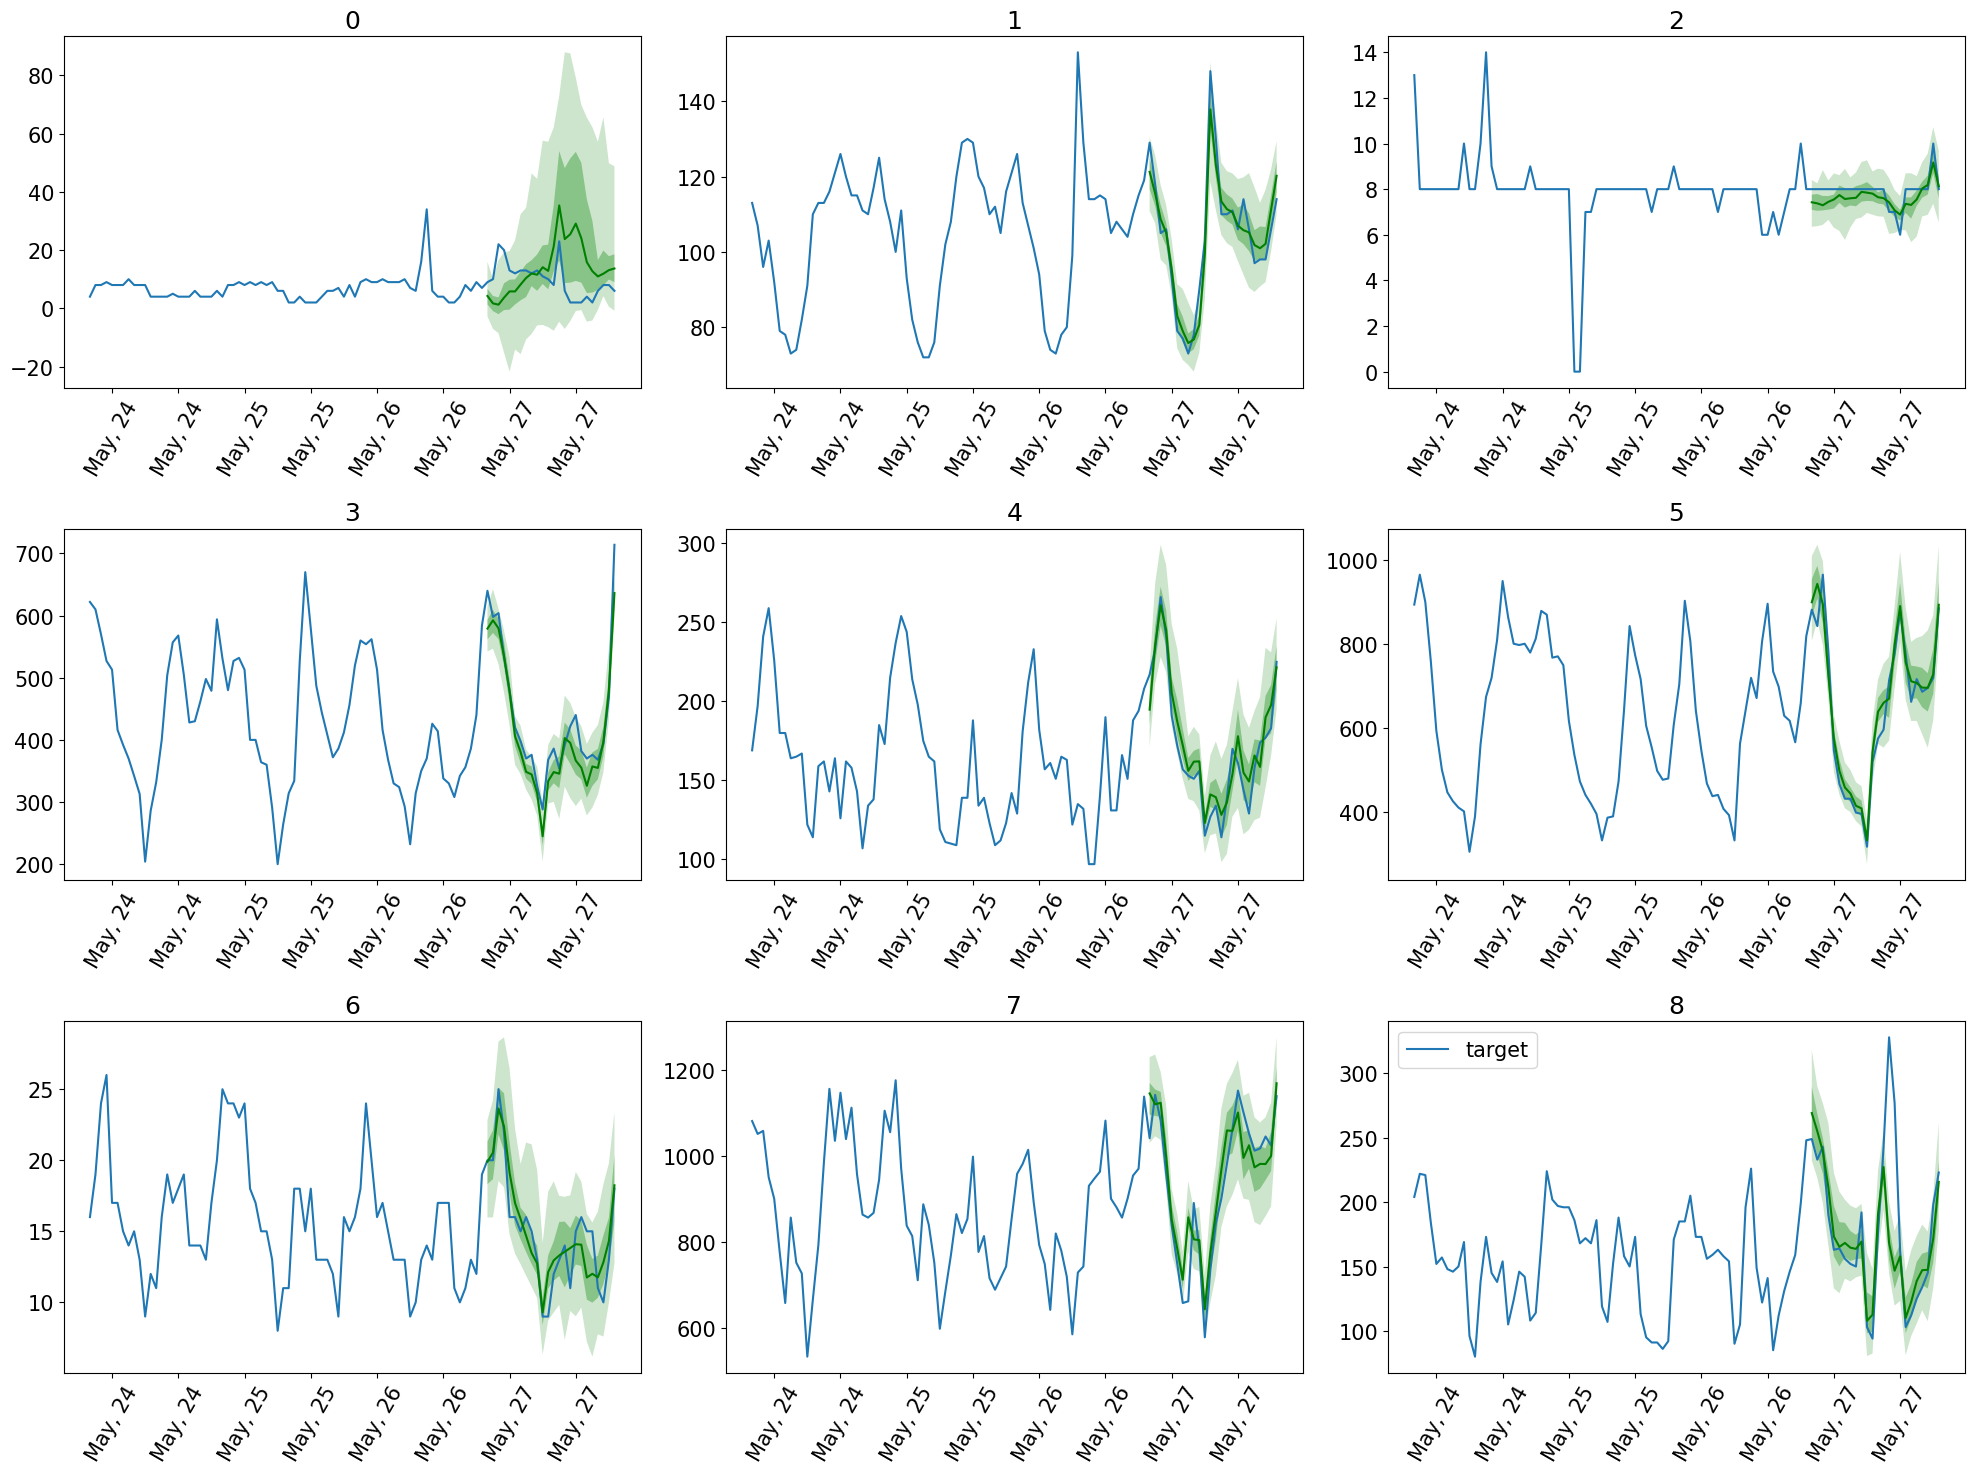

In [13]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    # Convert index for plot
    ts = ts[-4 * dataset.metadata.prediction_length:].to_timestamp()
    
    plt.plot(ts, label="target")
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()